<a href="https://colab.research.google.com/github/annauyenvu/21880284-19.20/blob/main/finetune_gpt_oss_ver1_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1
%%capture
# We're installing the latest Torch, Triton, OpenAI's Triton kernels, Transformers and Unsloth!
!pip install --upgrade -qqq uv
try: import numpy; install_numpy = f"numpy=={numpy.__version__}"
except: install_numpy = "numpy"
!uv pip install -qqq \
    "torch>=2.8.0" "triton>=3.4.0" {install_numpy} \
    "unsloth_zoo[base] @ git+https://github.com/unslothai/unsloth-zoo" \
    "unsloth[base] @ git+https://github.com/unslothai/unsloth" \
    torchvision bitsandbytes \
    git+https://github.com/huggingface/transformers \
    git+https://github.com/triton-lang/triton.git@05b2c186c1b6c9a08375389d5efe9cb4c401c075#subdirectory=python/triton_kernels

In [ ]:
#nếu lỗi version
!pip uninstall -y unsloth
!pip install --no-cache-dir "unsloth==2025.8.*"

Found existing installation: unsloth 2025.9.2
Uninstalling unsloth-2025.9.2:
  Successfully uninstalled unsloth-2025.9.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 56.1 MB/s eta 0:00:00


In [ ]:
#check ver
import sys, unsloth
print("unsloth =", getattr(unsloth, "__version__", "unknown"))
print("python  =", sys.version)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
unsloth = 2025.8.10
python  = 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


#load model

In [ ]:
#2
from unsloth import FastLanguageModel
import torch

max_seq_length = 1024
dtype = None
model_name = "unsloth/gpt-oss-20b"


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    dtype = dtype, # None for auto detection
    max_seq_length = max_seq_length, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

==((====))==  Unsloth 2025.8.10: Fast Gpt_Oss patching. Transformers: 4.57.0.dev0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gpt_oss won't work! Using float32.
Unsloth: Gpt_Oss does not support SDPA - switching to fast eager.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.37G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/27.9M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

#add lora

In [ ]:
#3
model = FastLanguageModel.get_peft_model(
    model,
    r = 8, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Making `model.base_model.model.model` require gradients


#before train

In [ ]:
#4
SYSTEM = (
    "You are an IELTS Writing Task 2 examiner. Evaluate according to the 4 criteria "
    "(Task Response, Coherence & Cohesion, Lexical Resource, Grammatical Range & Accuracy). "
    "Finally, write 'Band score: X.Y'. Present briefly and concisely."
)

USER = """Task:
Young people who commit crimes should be treated in the same way as adults who commit crimes. To what extent do you agree or disagree?

Essay:
Deciding to choose among the potential ways of punishing young people who commit crimes continues to be a controversial issue for the societies and the governments. It is argued by some that these people should be treated the same as adults. I personally disagree with this opinion due to the adverse effects of imprisonment on a teenager’s mental health. Many countries put the criminals of their society at jails considering it as a very effective way of punishment. It is understandable that this does exert a positive influence on decreasing crime in the society by putting the criminals in an unpleasant situation which they would mostly never wish to experience again. As a result, this could impede them from attempting crime in the future. For example, my friend who had been sent to jail for 2 months because of repeatedly committing traffic offends, has never committed the same crime since being released admitting that being in prison had been intolerable for her. However, I believe using the same way of punishment for youngsters would not be a wise idea. In fact, teenagers are at a very critical age in which the core of their personality is being shaped. There for, sending them to prison like adults as a way of punishment for their crimes, which are most often pity crimes, would actually expose them to other criminals who might have some serious personality disorders and this would adversely affect their personality as an adult in the future. To put in another way, such punishments are potential to become a threat to their mental health leading them to commit more serious crimes in a long run. For instance, according to the law of my country, young people are being punished the same as adults. A recent survey revealed that this policy has not been effective so far since 60% of these teenage criminals end up drug trafficking after being released from prison which had been sent to for a pity crime. In conclusion, although the ways that adults are being punished in many countries might be quite effective to decrease crime rate, I do not agree that it is a wise decision to use these ways for punishing young people as well.

Requirement: Please provide comments based on the 4 criteria and give a 'Band score:'.
"""

messages = [
    {"role": "system", "content": SYSTEM},
    {"role": "user", "content": USER},
]

inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
    return_dict = True,
).to(model.device)
from transformers import TextStreamer
_ = model.generate(**inputs, max_new_tokens = 512, streamer = TextStreamer(tokenizer))

<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-09-09

Reasoning: medium

# Valid channels: analysis, commentary, final. Channel must be included for every message.
Calls to these tools must go to the commentary channel: 'functions'.<|end|><|start|>developer<|message|># Instructions

You are an IELTS Writing Task 2 examiner. Evaluate according to the 4 criteria (Task Response, Coherence & Cohesion, Lexical Resource, Grammatical Range & Accuracy). Finally, write 'Band score: X.Y'. Present briefly and concisely.<|end|><|start|>user<|message|>Task:
Young people who commit crimes should be treated in the same way as adults who commit crimes. To what extent do you agree or disagree?

Essay:
Deciding to choose among the potential ways of punishing young people who commit crimes continues to be a controversial issue for the societies and the governments. It is argued by some that these people should be treated t

# load data

In [ ]:
#5 — Load train & valid CSVs + build messages + clean band
import re
from datasets import load_dataset

# Tách số đầu tiên trong chuỗi band (hỗ trợ "<4", ">=5.5", có \r, v.v.)
_num_pat = re.compile(r'(\d+(?:\.\d+)?)')

def to_float_band(x):
    if isinstance(x, (int, float)):
        return float(x)
    if not isinstance(x, str) or not x.strip():
        return None
    x = x.replace("\r", " ").replace("\n", " ").strip()
    m = _num_pat.search(x)
    return float(m.group(1)) if m else None

train_ds = load_dataset("csv", data_files="train.csv", split="train")
valid_ds = load_dataset("csv", data_files="valid.csv", split="train")

def build_messages(batch):
    prompts = batch["prompt"]
    essays  = batch["essay"]
    evals   = batch["evaluation"]
    bands   = batch["band"]

    out_msgs, out_band = [], []
    for p, e, ev, b in zip(prompts, essays, evals, bands):
        user_msg = f"Question:\n{p}\n\nEssay:\n{e}"
        assistant_msg = f"Evaluation:\n{ev}\n\nBand_score: {b}"
        out_msgs.append([
            {"role": "user", "content": user_msg},
            {"role": "assistant", "content": assistant_msg},
        ])
        out_band.append(to_float_band(b))  # <- band_gt đã sạch

    return {"messages": out_msgs, "band_gt": out_band}

orig_cols_train = list(train_ds.column_names)
orig_cols_valid = list(valid_ds.column_names)

train_ds = train_ds.map(build_messages, batched=True, remove_columns=orig_cols_train)
valid_ds = valid_ds.map(build_messages, batched=True, remove_columns=orig_cols_valid)
print("Loaded:", len(train_ds), "train samples,", len(valid_ds), "valid samples")

# Convert chat -> text cho cả 2 splits
def formatting_prompts_func(examples):
    texts = [
        tokenizer.apply_chat_template(
            convo, tokenize=False, add_generation_prompt=False
        )
        for convo in examples["messages"]
    ]
    return {"text": texts}

train_ds = train_ds.map(formatting_prompts_func, batched=True)
valid_ds = valid_ds.map(formatting_prompts_func, batched=True)


Loaded: 495 train samples, 50 valid samples


In [ ]:
#6 Convert chat messages -> plain 'text' using model's chat template (for SFT)

def formatting_prompts_func(examples):
    convos = examples["messages"]
    texts = [
        tokenizer.apply_chat_template(
            convo,
            tokenize=False,
            add_generation_prompt=False,
        )
        for convo in convos
    ]
    return {"text": texts}

train_ds = train_ds.map(formatting_prompts_func, batched=True)
valid_ds = valid_ds.map(formatting_prompts_func, batched=True)

print(train_ds[0]["messages"])
print("\n====== Rendered text (train[0]) ======\n")
print(train_ds[0]["text"][:600])

[{'content': 'Question:\nIn many countries, more and more young people are leaving school and unable to find job after graduation. What peoblem do you think youth unemployment will cause to the individual and society? Give reasons and make suggestion.\n\nEssay:\nUnemployment in young generation is one of the major concerns in many nations, as schools are regularly producing scholars, but they are unable to earn bread and butter. There are various issues that have been caused by unemployment, which are described in upcoming fragments along with its solutions.\r\nTo embark with, there are numerous problems associated with the unavailability of jobs on personal as well as community level. Firstly, workless youngsters remains unoccupied for most of the time. Due to which, they get easily indulge in malpractices such as drugs, juvenile delinquency, cyber crime and many more. Apart from this, it inculcates discouragement among other brilliant students and they lack interest in academics.  Ow

In [ ]:
#7
print(train_ds[0]["messages"])
print("\n====== Rendered text (train[0]) ======\n")
print(train_ds[0]["text"][:600])


[{'content': 'Question:\nIn many countries, more and more young people are leaving school and unable to find job after graduation. What peoblem do you think youth unemployment will cause to the individual and society? Give reasons and make suggestion.\n\nEssay:\nUnemployment in young generation is one of the major concerns in many nations, as schools are regularly producing scholars, but they are unable to earn bread and butter. There are various issues that have been caused by unemployment, which are described in upcoming fragments along with its solutions.\r\nTo embark with, there are numerous problems associated with the unavailability of jobs on personal as well as community level. Firstly, workless youngsters remains unoccupied for most of the time. Due to which, they get easily indulge in malpractices such as drugs, juvenile delinquency, cyber crime and many more. Apart from this, it inculcates discouragement among other brilliant students and they lack interest in academics.  Ow

In [ ]:
#8 - Configure Trainer
from trl import SFTConfig, SFTTrainer
#sửa config cho 500 mẫu
cfg = SFTConfig(
    dataset_text_field="text",
    packing=True,
    max_seq_length=512,              # giữ để tránh OOM
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,    # hiệu batch = 8
    # train=500:
    num_train_epochs=1,               # tổng steps ≈ 63
    learning_rate=1e-4,               # LR nhỏ hơn để học ổn qua nhiều epoch
    warmup_steps=5,                # THAY cho warmup_ratio thường 0.03
    logging_steps=5,
    eval_strategy="steps",
    eval_steps=20,                    # 20 steps 1 lần eval
    eval_accumulation_steps=8,        # giảm VRAM khi eval (gom nhiều step mới sync)
    save_strategy="no",
    fp16=False,                       # gpt-oss thường ép về fp32; tắt để đỡ cảnh báo
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    seed=3407,
    output_dir="outputs",
    report_to="none",
    remove_unused_columns=False,

     # 2 flag giảm VRAM:
    gradient_checkpointing=True,
    auto_find_batch_size=False,         # tránh vòng giảm batch -> 0 gây lỗi
    group_by_length=True,               # sắp xếp theo độ dài để giảm padding dư
)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    args=cfg,
)


Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/50 [00:00<?, ? examples/s]

Unsloth: Packing eval dataset (num_proc=6):   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
#9 train model (fine-tune)
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 495 | Num Epochs = 1 | Total steps = 62
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 3,981,312 of 20,918,738,496 (0.02% trained)


Step,Training Loss,Validation Loss
20,2.461900,2.281867
40,2.197300,2.141551
60,2.227100,2.126011


In [ ]:
#cell 10
model.save_pretrained("finetuned_model")

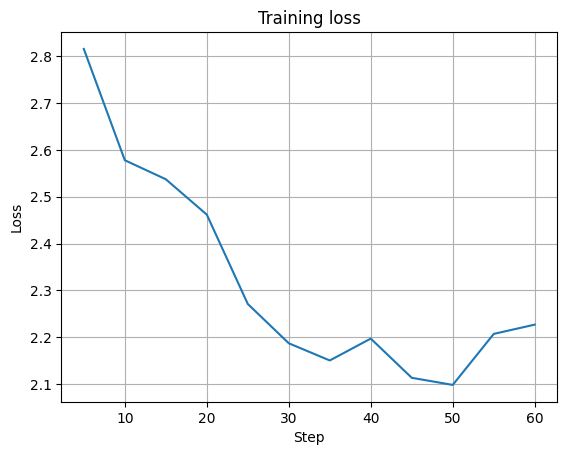

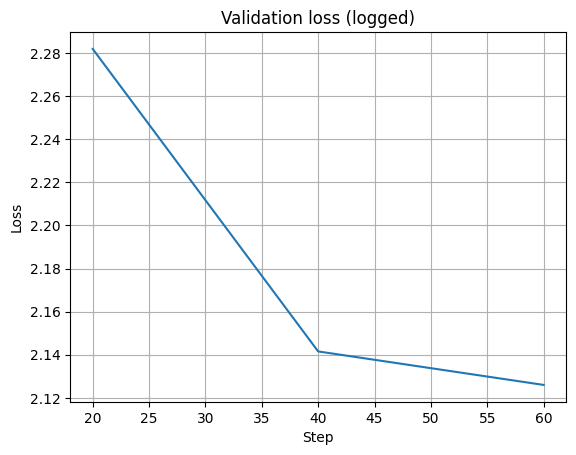

In [ ]:
# 11 PLOT CURVES (TRAIN/VALID LOSS & VALID ACCURACY)
import pandas as pd
import matplotlib.pyplot as plt

log_hist = getattr(trainer.state, "log_history", [])
df = pd.DataFrame(log_hist)

# 1) Training loss theo step
if "loss" in df.columns:
    df_loss = df.dropna(subset=["loss"])[["step", "loss"]]
    if not df_loss.empty:
        plt.figure()
        plt.plot(df_loss["step"], df_loss["loss"])
        plt.title("Training loss")
        plt.xlabel("Step"); plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

# 2) Validation loss theo step (nếu có trong log), nếu không có thì vẽ từ metrics vừa tính
plotted_val = False
if "eval_loss" in df.columns:
    df_vloss = df.dropna(subset=["eval_loss"])[["step", "eval_loss"]]
    if not df_vloss.empty:
        plt.figure()
        plt.plot(df_vloss["step"], df_vloss["eval_loss"])
        plt.title("Validation loss (logged)")
        plt.xlabel("Step"); plt.ylabel("Loss")
        plt.grid(True)
        plt.show()
        plotted_val = True

# 3) Nếu không có eval_loss trong log, chấm điểm cuối từ file metrics
if not plotted_val:
    import json, os
    points = []
    for p in ["outputs/metrics_validation.json", "outputs/metrics_training.json"]:
        if os.path.exists(p):
            with open(p) as f:
                m = json.load(f)
            # tìm key *_loss gần nhất
            for k in ["val_loss","val_subset_loss","eval_loss","train_loss","train_subset_loss"]:
                if k in m:
                    points.append((k, m[k]))
    if points:
        plt.figure()
        xs = list(range(len(points)))
        ys = [v for _, v in points]
        labels = [k for k, _ in points]
        plt.plot(xs, ys, marker="o")
        plt.xticks(xs, labels, rotation=30)
        plt.title("Loss (end-of-run)")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

# 4) Validation accuracy (nếu compute_metrics có trả về)
if "eval_accuracy" in df.columns:
    df_vacc = df.dropna(subset=["eval_accuracy"])[["step","eval_accuracy"]]
    if not df_vacc.empty:
        plt.figure()
        plt.plot(df_vacc["step"], df_vacc["eval_accuracy"])
        plt.title("Validation token accuracy")
        plt.xlabel("Step"); plt.ylabel("Accuracy")
        plt.grid(True)
        plt.show()


In [ ]:
# 12 SAVE LoRA ADAPTER & TOKENIZER
import os
os.makedirs("lora_adapter", exist_ok=True)
os.makedirs("lora_tokenizer", exist_ok=True)

# Lưu adapter (PEFT/Unsloth đều hỗ trợ save_pretrained qua wrapper)
model.save_pretrained("lora_adapter")
tokenizer.save_pretrained("lora_tokenizer")

print("✅ Saved LoRA adapter -> lora_adapter/")
print("✅ Saved tokenizer    -> lora_tokenizer/")


✅ Saved LoRA adapter -> lora_adapter/
✅ Saved tokenizer    -> lora_tokenizer/


# after

In [ ]:
SYSTEM = (
    "You are an IELTS Writing Task 2 examiner. Evaluate according to the 4 criteria "
    "(Task Response, Coherence & Cohesion, Lexical Resource, Grammatical Range & Accuracy). "
    "Finally, write 'Band score: X.Y'. Present briefly and concisely."
)

USER = """Task:
In many countries, more and more young people are leaving school and unable to find jobs after graduation. What problems do you think youth unemployment will cause to the individual and the society? Give reasons and make some suggestions.

Essay:
Recently, it has become a serious social concern that college graduates cannot find a job after they step into the real world. This essay will discuss the consequences of this problem and offer suggestions.

One of the main reasons for the above phenomenon partly lies in its own responsibility. Firstly, they might have not made sufficient preparation in terms of professional knowledge. Secondly, graduates' request for work conditions might be unreasonable. For example, although on average an employee with three years' experience can earn a monthly salary of 300 pounds, it is not uncommon for numerous graduates to ask for a sum much higher than that. Of course, an employer would probably not be willing to give them the offer.

There are also some social reasons to explain graduate unemployment. First, the worldwide economy has slumped, especially after the 2008 financial crisis, so the job market has greatly shrunk and not a sufficient number of jobs can be provided. Second, the improper design of curricula has also contributed to the problem of youth unemployment. To illustrate, the percentage of practical courses in my department is less than 20% , leading to the shortage of working skills in my classmates. But actually a proportion of 50% might prove to be proper to train a graduate popular among potential employers.

Therefore, some measures should be taken to solve this problem. To start with, students should work hard to prepare themselves well in their own field and should have a suitable expectation with regard to salaries. Moreover, the government should attempt to create job opportunities, e. g., in the area of alternative energy, while the education authorities should increase the proportion of practical courses in the curricula.

Requirement: Please respond strictly in the following format:
Task Response: ...
Coherence & Cohesion: ...
Lexical Resource: ...
Grammatical Range & Accuracy: ...
Band score: X.Y
"""

messages = [
    {"role": "system", "content": SYSTEM},
    {"role": "user", "content": USER},
]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
    return_dict = True,
    reasoning_effort = "low",
).to(model.device)
from transformers import TextStreamer
_ = model.generate(**inputs, max_new_tokens = 512, streamer = TextStreamer(tokenizer))

In [ ]:
# Cell 11 — Inference IELTS Writing Task 2 (với model đang ở RAM)

import torch
from transformers import TextStreamer

# Gợi ý: nên bám format dữ liệu train của bạn (Đánh giá + Điểm band) để model ra 'đúng kiểu'
SYSTEM = (
    "You are an IELTS Writing Task 2 examiner. Evaluate according to the 4 criteria "
    "(Task Response, Coherence & Cohesion, Lexical Resource, Grammatical Range & Accuracy). "
    "Finally, write 'Band score: X.Y'. Present briefly and concisely."
)

USER = """Task:
In many countries, more and more young people are leaving school and unable to find jobs after graduation. What problems do you think youth unemployment will cause to the individual and the society? Give reasons and make some suggestions.

Essay:
Recently, it has become a serious social concern that college graduates cannot find a job after they step into the real world. This essay will discuss the consequences of this problem and offer suggestions.

One of the main reasons for the above phenomenon partly lies in its own responsibility. Firstly, they might have not made sufficient preparation in terms of professional knowledge. Secondly, graduates' request for work conditions might be unreasonable. For example, although on average an employee with three years' experience can earn a monthly salary of 300 pounds, it is not uncommon for numerous graduates to ask for a sum much higher than that. Of course, an employer would probably not be willing to give them the offer.

There are also some social reasons to explain graduate unemployment. First, the worldwide economy has slumped, especially after the 2008 financial crisis, so the job market has greatly shrunk and not a sufficient number of jobs can be provided. Second, the improper design of curricula has also contributed to the problem of youth unemployment. To illustrate, the percentage of practical courses in my department is less than 20% , leading to the shortage of working skills in my classmates. But actually a proportion of 50% might prove to be proper to train a graduate popular among potential employers.

Therefore, some measures should be taken to solve this problem. To start with, students should work hard to prepare themselves well in their own field and should have a suitable expectation with regard to salaries. Moreover, the government should attempt to create job opportunities, e. g., in the area of alternative energy, while the education authorities should increase the proportion of practical courses in the curricula.

Requirement: Please respond strictly in the following format:
Task Response: ...
Coherence & Cohesion: ...
Lexical Resource: ...
Grammatical Range & Accuracy: ...
Band score: X.Y
"""

messages = [
    {"role": "system", "content": SYSTEM},
    {"role": "user", "content": USER},
]

inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    reasoning_effort = "low",
).to(model.device)

gen_kwargs = dict(
    max_new_tokens=400,
    temperature=0.2,
    top_p=0.9,
    do_sample=True,
    eos_token_id=tokenizer.eos_token_id,
)

streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer=streamer, **gen_kwargs)
